## Fine-Tuning BERT Model - Experiment Version 2

___
Install Libraries

In [1]:
!pip install transformers
!pip install tensorflow

___
Install Libraries

In [2]:
import torch
import pandas as pd
import numpy as np
import nltk
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from google.colab import files
from sklearn.metrics import accuracy_score, f1_score
from nltk.sentiment import SentimentIntensityAnalyzer

___
Check GPU

In [3]:
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    dev = torch.device("cpu")
    print("GPU not available, using CPU.")

Using GPU: Tesla T4


Upload and Load Dataset

In [4]:
print("\n--- Loading and Preprocessing Data ---")
# Upload CSV file
uploaded_files = files.upload()

# Load dataset file
data_df = pd.read_csv('Philippines-News-Headlines-Dataset-for-Sentiment-Analysis.csv')


--- Loading and Preprocessing Data ---


Saving Philippines-News-Headlines-Dataset-for-Sentiment-Analysis.csv to Philippines-News-Headlines-Dataset-for-Sentiment-Analysis.csv


Generate Labels with VADER

In [5]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to convert VADER compound score to label
def get_sentiment_label(compound_score):
  if compound_score >= 0.05:
      return 2 # Positive
  elif compound_score <= -0.05:
      return 0 # Negative
  else:
      return 1 # Neutral

# Apply VADER to each headline to generate rough labels
data_df['sentiment_score'] = data_df['Headlines'].apply(lambda x: sentiment_analyzer.polarity_scores(str(x))['compound'])
data_df['label'] = data_df['sentiment_score'].apply(get_sentiment_label)

print("Sample of headlines with generated labels:")
print(data_df[['Headlines', 'sentiment_score', 'label']].head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sample of headlines with generated labels:
                                           Headlines  sentiment_score  label
0                                Miranda's doctrine.              0.0      1
1    US equity firm looks to more investments in PH.              0.0      1
2  Nickel Asia Corp Announces its Notice of Annua...              0.0      1
3                    DoF reconvenes the Green Force.              0.0      1
4                  Cebu MSMEs get training from DTI.              0.0      1


Create Training/Eval Datasets

In [6]:
# Convert to Huggingface Dataset format using the generated labels
headline_texts = data_df['Headlines'].tolist()
sentiment_labels = data_df['label'].tolist()
hf_dataset = Dataset.from_dict({"text": headline_texts, "label": sentiment_labels})

# Select a subset for training and evaluation
training_set = hf_dataset.select(range(2000))
eval_set = hf_dataset.select(range(500))

print("Loaded dataset with {} training and {} evaluation samples.".format(len(training_set), len(eval_set)))

Loaded dataset with 2000 training and 500 evaluation samples.


Load Tokenizer

In [7]:
# Initialize Tokenizer (the pre-processing tool)
PRETRAINED_MODEL = "ProsusAI/finbert"
model_tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenize Datasets

In [8]:
def process_tokenization(examples):
    # This prepares the text and converts it into numerical IDs that the model understands
    return model_tokenizer(examples["text"], truncation=True, padding=True)

# Apply tokenization to the training and evaluating sets
train_tokenized = training_set.map(process_tokenization, batched=True)
eval_tokenized = eval_set.map(process_tokenization, batched=True)

# Rename the 'label' column to 'labels' for the Hugging Face Trainer
train_tokenized = train_tokenized.rename_column("label", "labels")
eval_tokenized = eval_tokenized.rename_column("label", "labels")

# Set the format to PyTorch tensors
train_tokenized.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
eval_tokenized.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Load Model

In [9]:
# Load the pre-trained DistilBERT model for sequence classification (sentiment analysis)
classification_model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=3).to(dev)
print(f"Model loaded: {PRETRAINED_MODEL}")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Model loaded: ProsusAI/finbert


Define Metrics Function

In [10]:
def calculate_metrics(pred):
    # This function calculates key metrics during evaluation
    predictions = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(pred.label_ids, predictions)
    f1 = f1_score(pred.label_ids, predictions, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

Configure Training Arguments

In [11]:
# Define training arguments (hyperparameters) - MODIFIED FOR EXPERIMENT V2
train_config = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.2,
    logging_dir="'./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to=[]
)

Initialize Trainer

In [12]:
# Initialize the Trainer
model_trainer = Trainer(
    model=classification_model,
    args=train_config,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    compute_metrics=calculate_metrics,
    processing_class=model_tokenizer,
)

Train the Model

In [13]:
print("\n --- Starting Fine-Tuning (Expected Time: 1-4 hours on GPU)")
model_trainer.train()


 --- Starting Fine-Tuning (Expected Time: 1-4 hours on GPU)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.078723,0.590000,0.522855
2,1.521500,0.752881,0.702000,0.654291
3,1.521500,0.483822,0.822000,0.804113
4,0.757900,0.290760,0.908000,0.904527
5,0.444600,0.168702,0.950000,0.950315


TrainOutput(global_step=315, training_loss=0.881920840248229, metrics={'train_runtime': 85.2214, 'train_samples_per_second': 117.341, 'train_steps_per_second': 3.696, 'total_flos': 133612282440000.0, 'train_loss': 0.881920840248229, 'epoch': 5.0})

Evaluate

In [14]:
print("\n--- Final Evaluation Results ---")
final_eval_results = model_trainer.evaluate()
print(final_eval_results)
print("\nFine-tuning process complete. The resulting model can now be used for inference (Stage 4).")


--- Final Evaluation Results ---


{'eval_loss': 0.1687019020318985, 'eval_accuracy': 0.95, 'eval_f1': 0.9503150777119735, 'eval_runtime': 0.5026, 'eval_samples_per_second': 994.78, 'eval_steps_per_second': 63.666, 'epoch': 5.0}

Fine-tuning process complete. The resulting model can now be used for inference (Stage 4).


Training History

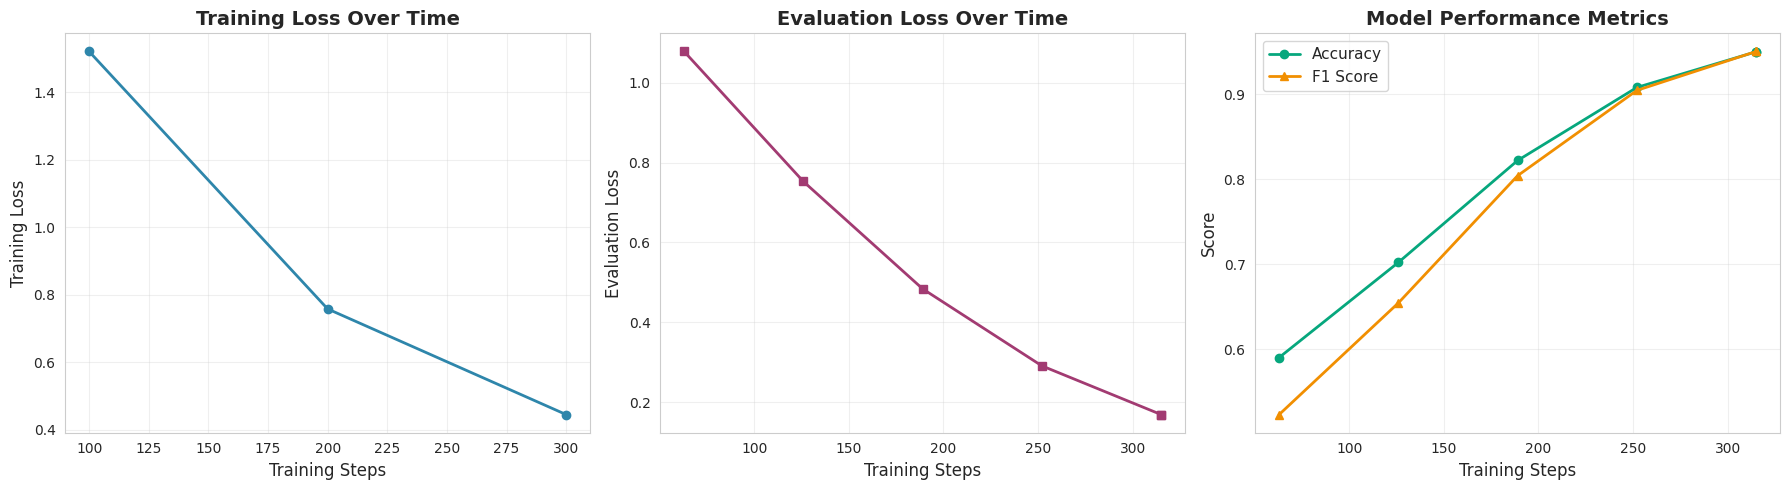


Final Training Loss: 0.4446
Final Evaluation Loss: 0.1687
Final Accuracy: 0.9500
Final F1 Score: 0.9503


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# Extract training history from the trainer
training_logs = model_trainer.state.log_history

# Separate training and evaluation logs
train_loss = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
train_steps = []
eval_steps = []

for log in training_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
        train_steps.append(log['step'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
        eval_accuracy.append(log['eval_accuracy'])
        eval_f1.append(log['eval_f1'])
        eval_steps.append(log['step'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training Loss
axes[0].plot(train_steps, train_loss, marker='o', linewidth=2, markersize=6, color='#2E86AB')
axes[0].set_xlabel('Training Steps', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Evaluation Loss
axes[1].plot(eval_steps, eval_loss, marker='s', linewidth=2, markersize=6, color='#A23B72')
axes[1].set_xlabel('Training Steps', fontsize=12)
axes[1].set_ylabel('Evaluation Loss', fontsize=12)
axes[1].set_title('Evaluation Loss Over Time', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy and F1 Score
axes[2].plot(eval_steps, eval_accuracy, marker='o', linewidth=2, markersize=6, label='Accuracy', color='#06A77D')
axes[2].plot(eval_steps, eval_f1, marker='^', linewidth=2, markersize=6, label='F1 Score', color='#F18F01')
axes[2].set_xlabel('Training Steps', fontsize=12)
axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_loss[-1]:.4f}")
print(f"Final Evaluation Loss: {eval_loss[-1]:.4f}")
print(f"Final Accuracy: {eval_accuracy[-1]:.4f}")
print(f"Final F1 Score: {eval_f1[-1]:.4f}")

Create Inference Pipeline

In [16]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=classification_model,
    tokenizer=model_tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

test_headlines = [
    "This Social-Media Stock Is Down 20% Today.",
    "Banks may face distress if Covid persists according to Diokno.",
    "PH economy to shrink by over 10% in Apr-Jun'.",
]

Device set to use cuda:0


Run Inference

In [17]:
print("\n--- Running Inference on Unlabeled Data ---")
inference_results = sentiment_pipeline(test_headlines)

sentiment_mapping = {
    "negative": "Negative",
    "neutral": "Neutral",
    "positive": "Positive"
}

for headline, result in zip(test_headlines, inference_results):
    predicted_sentiment = sentiment_mapping.get(result['label'].lower(), "Unknown")
    print(f"Text: {headline}")
    print(f" Prediction: {predicted_sentiment} (Score: {result['score']:.4f})")


--- Running Inference on Unlabeled Data ---
Text: This Social-Media Stock Is Down 20% Today.
 Prediction: Negative (Score: 0.9798)
Text: Banks may face distress if Covid persists according to Diokno.
 Prediction: Negative (Score: 0.8983)
Text: PH economy to shrink by over 10% in Apr-Jun'.
 Prediction: Negative (Score: 0.9280)


 Label Distribution

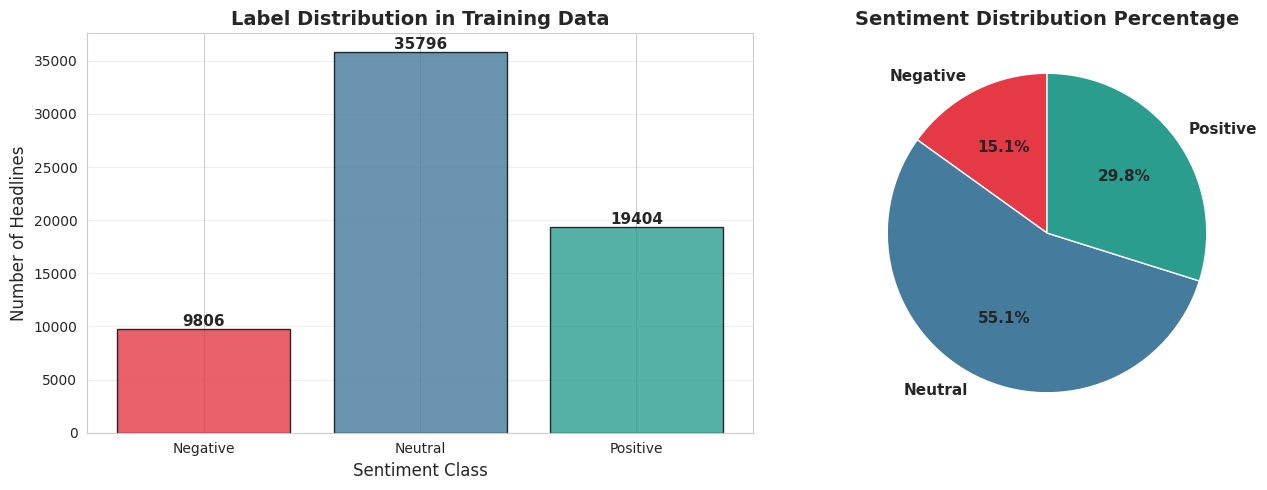


Dataset Statistics:
Total headlines: 65006
Negative: 9806 (15.1%)
Neutral: 35796 (55.1%)
Positive: 19404 (29.8%)


In [18]:
# Count label distribution in the original dataset
label_counts = data_df['label'].value_counts().sort_index()
label_names = ['Negative', 'Neutral', 'Positive']

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#E63946', '#457B9D', '#2A9D8F']
axes[0].bar(label_names, label_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Sentiment Class', fontsize=12)
axes[0].set_ylabel('Number of Headlines', fontsize=12)
axes[0].set_title('Label Distribution in Training Data', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (name, count) in enumerate(zip(label_names, label_counts.values)):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(label_counts.values, labels=label_names, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Sentiment Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDataset Statistics:")
print(f"Total headlines: {len(data_df)}")
for i, name in enumerate(label_names):
    print(f"{name}: {label_counts.values[i]} ({label_counts.values[i]/len(data_df)*100:.1f}%)")

Inference Results

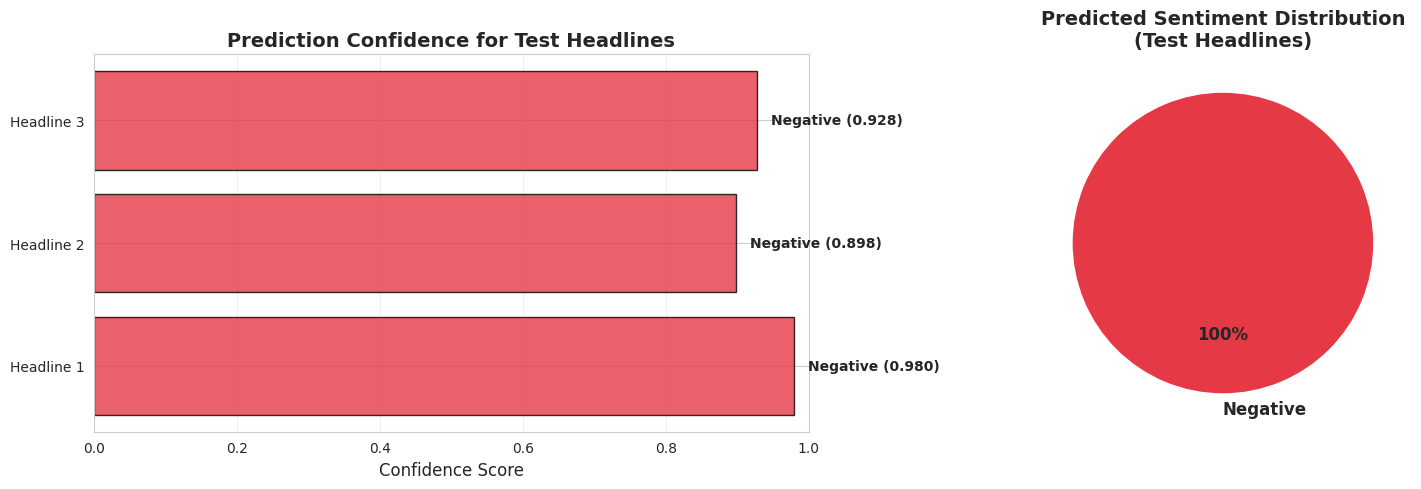


DETAILED INFERENCE RESULTS

[Headline 1]
Text: This Social-Media Stock Is Down 20% Today.
Predicted Sentiment: Negative
Confidence Score: 0.9798

[Headline 2]
Text: Banks may face distress if Covid persists according to Diokno.
Predicted Sentiment: Negative
Confidence Score: 0.8983

[Headline 3]
Text: PH economy to shrink by over 10% in Apr-Jun'.
Predicted Sentiment: Negative
Confidence Score: 0.9280



In [19]:
# Extract predictions for visualization
predicted_labels = [sentiment_mapping.get(r['label'].lower(), "Unknown") for r in inference_results]
confidence_scores = [r['score'] for r in inference_results]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Confidence scores by headline
x_pos = range(len(test_headlines))
bar_colors = ['#E63946' if l=='Negative' else '#2A9D8F' if l=='Positive' else '#457B9D' for l in predicted_labels]

bars = axes[0].barh(x_pos, confidence_scores, color=bar_colors, alpha=0.8, edgecolor='black')
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels([f"Headline {i+1}" for i in range(len(test_headlines))], fontsize=10)
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_title('Prediction Confidence for Test Headlines', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# Add score labels
for i, (score, label) in enumerate(zip(confidence_scores, predicted_labels)):
    axes[0].text(score + 0.02, i, f"{label} ({score:.3f})", va='center', fontsize=10, fontweight='bold')

# Plot 2: Predicted sentiment distribution
pred_counts = {}
for label in predicted_labels:
    pred_counts[label] = pred_counts.get(label, 0) + 1

pie_colors = []
pie_labels = []
pie_values = []
color_map = {'Negative': '#E63946', 'Neutral': '#457B9D', 'Positive': '#2A9D8F'}

for label in ['Negative', 'Neutral', 'Positive']:
    if label in pred_counts:
        pie_labels.append(label)
        pie_values.append(pred_counts[label])
        pie_colors.append(color_map[label])

axes[1].pie(pie_values, labels=pie_labels, colors=pie_colors, autopct='%1.0f%%',
            startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Predicted Sentiment Distribution\n(Test Headlines)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*80)
print("DETAILED INFERENCE RESULTS")
print("="*80)
for i, (headline, pred_label, score) in enumerate(zip(test_headlines, predicted_labels, confidence_scores), 1):
    print(f"\n[Headline {i}]")
    print(f"Text: {headline}")
    print(f"Predicted Sentiment: {pred_label}")
    print(f"Confidence Score: {score:.4f}")
print("\n" + "="*80)